# Helmet Detection

## importing tf and checking gpu availability

In [1]:
# creating folders to upload data
!mkdir -p Helmet/train/images Helmet/test/images Helmet/train/labels Helmet/test/labels

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4157870604420060788
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7298411345735471123
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


## Labeling

In [4]:
## datas are labeld using labelme

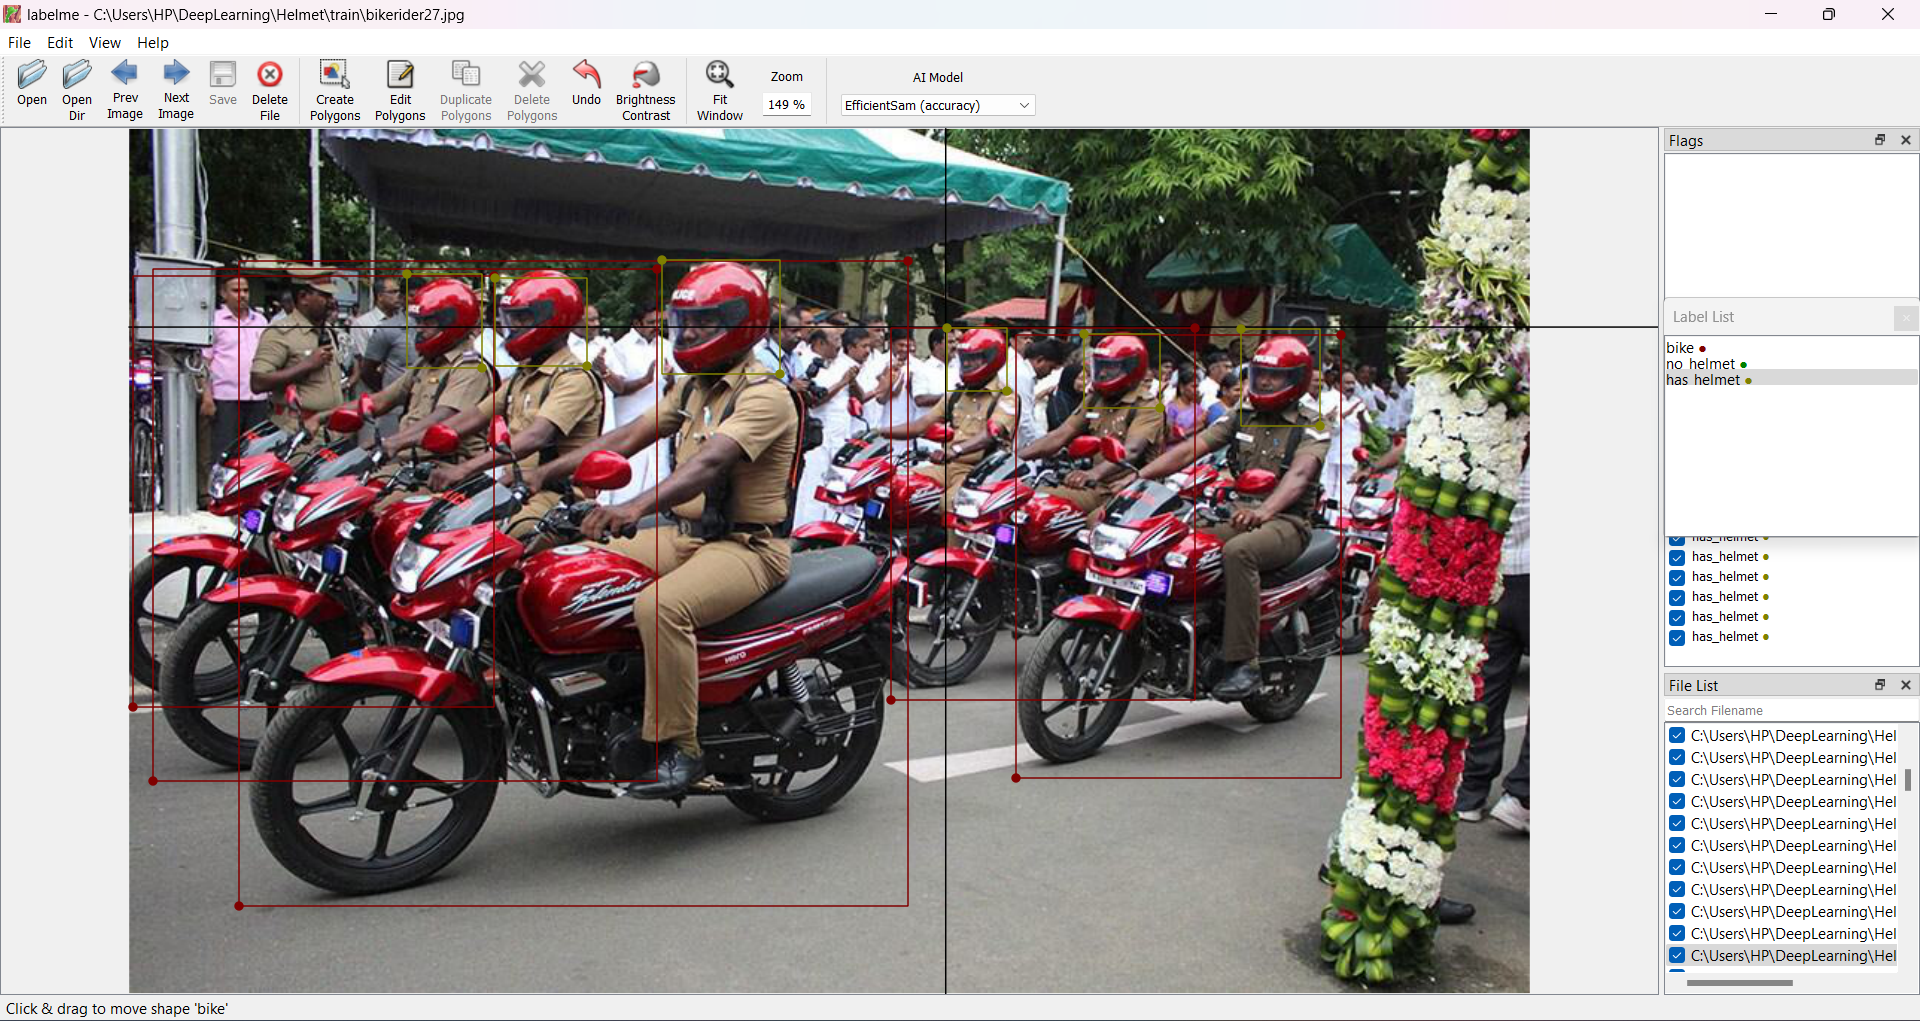

### Import libraries

In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

In [6]:
train = tf.data.Dataset.list_files('Helmet/train/images/*.jpg')

def resize_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image)
  image = tf.image.resize(image, (300, 300))
  image = image / 255.0
  return image

train = train.map(resize_image)


In [7]:
train.as_numpy_iterator().next()

array([[[0.44764706, 0.4319608 , 0.3927451 ],
        [0.45656863, 0.44088235, 0.40558824],
        [0.42784312, 0.40823528, 0.38470587],
        ...,
        [0.37686273, 0.4317647 , 0.3690196 ],
        [0.40892157, 0.46186274, 0.4167647 ],
        [0.7448039 , 0.80754906, 0.7683333 ]],

       [[0.4614706 , 0.44578433, 0.4104902 ],
        [0.47127452, 0.45362747, 0.4242157 ],
        [0.42245096, 0.40284312, 0.38323528],
        ...,
        [0.49990195, 0.55480397, 0.4920588 ],
        [0.5348039 , 0.597549  , 0.5504902 ],
        [0.8136275 , 0.8763726 , 0.8371569 ]],

       [[0.40882352, 0.4014706 , 0.3647059 ],
        [0.41813725, 0.4107843 , 0.38186276],
        [0.36372548, 0.35637254, 0.33137256],
        ...,
        [0.49166667, 0.55833334, 0.48578432],
        [0.65882355, 0.7235294 , 0.6666667 ],
        [0.87647057, 0.93921566, 0.8960784 ]],

       ...,

       [[0.43382353, 0.45735294, 0.40245098],
        [0.43823528, 0.4617647 , 0.40686274],
        [0.4259804 , 0

In [8]:
type(train)

tensorflow.python.data.ops.map_op._MapDataset

### View Raw Images with Matplotlib

In [9]:
image_generator = train.batch(8).as_numpy_iterator()

In [10]:
plot_images = image_generator.next()

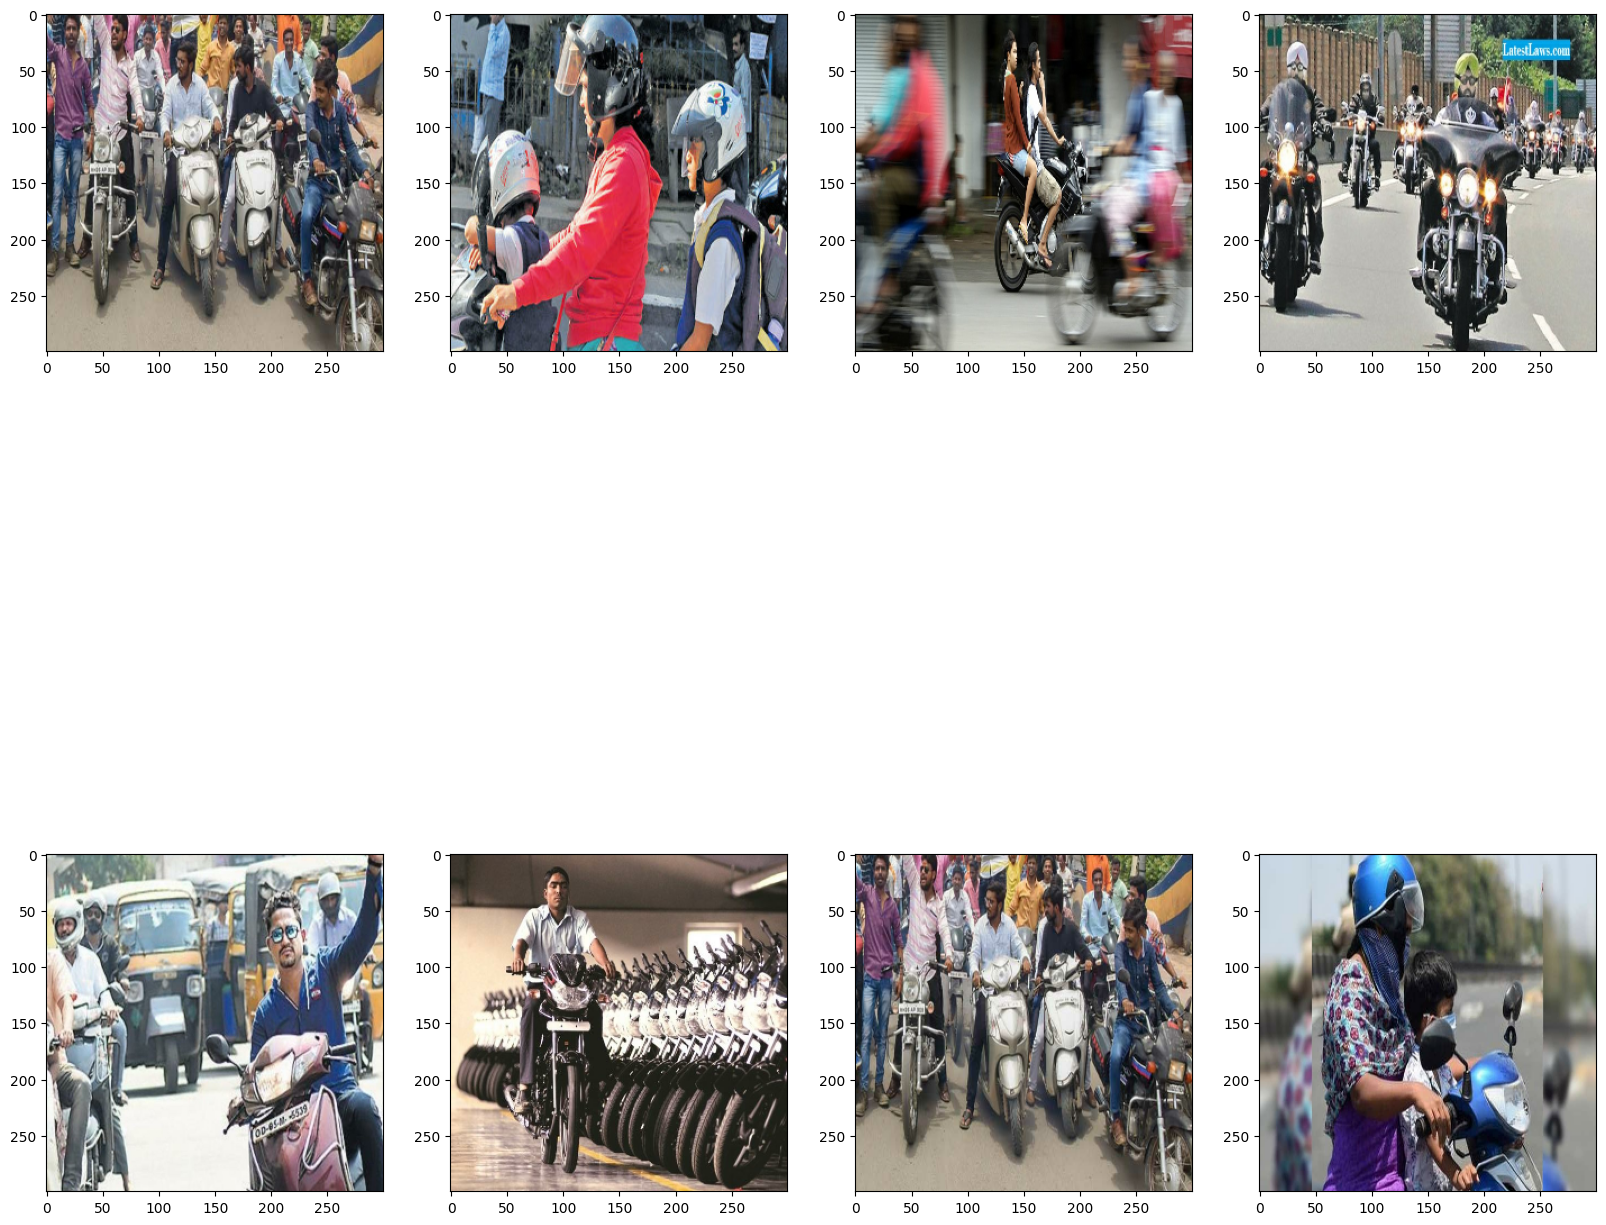

In [11]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20, 20))
for row_idx in range(2):
    for col_idx in range(4):
        ax[row_idx, col_idx].imshow(plot_images[row_idx * 4 + col_idx])
plt.show()

## Apply Image Augmentation on Images and Labels using Albumentations

In [12]:
import json

with open('/content/Helmet/train/labels/bikerider0.json',) as f:
   test = json.load(f)

In [13]:
type(test)

dict

In [14]:
test.keys()

dict_keys(['version', 'flags', 'shapes', 'imagePath', 'imageData', 'imageHeight', 'imageWidth'])

In [15]:
test['shapes']

[{'label': 'bike',
  'points': [[346.3503649635037, 19.839416058394164],
   [733.9416058394161, 624.948905109489]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {},
  'mask': None},
 {'label': 'bike',
  'points': [[173.3576642335767, 26.408759124087595],
   [408.39416058394164, 493.5620437956204]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {},
  'mask': None},
 {'label': 'bike',
  'points': [[747.8102189781022, 33.70802919708029],
   [881.3868613138686, 313.2700729927007]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {},
  'mask': None},
 {'label': 'bike',
  'points': [[955.8394160583941, 2.3211678832116838],
   [1198.8511579916774, 627.0]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {},
  'mask': None},
 {'label': 'no_helmet',
  'points': [[564.5985401459855, 173.12408759124088],
   [468.97810218978105, 29.328467153284674]],
  'group_id'

In [16]:
type(test['shapes'])

list

In [17]:
shape = test['shapes']

In [18]:
len(shape)

10

In [19]:
coords = {}
bikelist = []
nh_list = []
hh_list = []
for item in shape:
    if item['label'] == 'bike':
      coord =[0,0,0,0]
      coord[0] = item['points'][0][0]
      coord[1] = item['points'][0][1]
      coord[2] = item['points'][1][0]
      coord[3] = item['points'][1][1]
      bikelist.append(coord)
    elif item['label'] == 'no_helmet':
      coord =[0,0,0,0]
      coord[0] = item['points'][0][0]
      coord[1] = item['points'][0][1]
      coord[2] = item['points'][1][0]
      coord[3] = item['points'][1][1]
      nh_list.append(coord)
    elif item['label'] == 'has_helmet':
      coord =[0,0,0,0]
      coord[0] = item['points'][0][0]
      coord[1] = item['points'][0][1]
      coord[2] = item['points'][1][0]
      coord[3] = item['points'][1][1]
      hh_list.append(coord)

In [20]:
bikelist

[[346.3503649635037, 19.839416058394164, 733.9416058394161, 624.948905109489],
 [173.3576642335767,
  26.408759124087595,
  408.39416058394164,
  493.5620437956204],
 [747.8102189781022, 33.70802919708029, 881.3868613138686, 313.2700729927007],
 [955.8394160583941, 2.3211678832116838, 1198.8511579916774, 627.0]]

In [21]:
nh_list

[[564.5985401459855,
  173.12408759124088,
  468.97810218978105,
  29.328467153284674],
 [411.31386861313877,
  22.029197080291972,
  508.3941605839417,
  145.38686131386862],
 [250.00000000000009,
  36.627737226277375,
  316.42335766423366,
  119.83941605839416],
 [584.3065693430657,
  55.605839416058394,
  621.5328467153286,
  103.78102189781022]]

In [22]:
hh_list

[[843.4306569343066, 97.21167883211679, 794.5255474452555, 40.277372262773724],
 [1197.4452554744526,
  127.86861313868613,
  1080.6569343065694,
  3.781021897810224]]

In [23]:
#Apply Augmentations and View Results

In [24]:
img = cv2.imread('/content/Helmet/train/images/bikerider0.jpg')

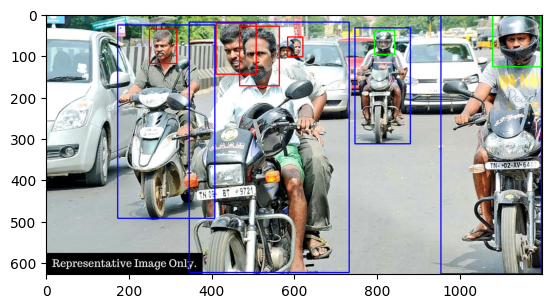

In [25]:
# Color map for different
# cv2 is BGR is BGR Format
color_map = {
    'bike': (255, 0, 0),       # Blue for bike
    'no_helmet': (0, 0, 255),  # Green for no_helmet
    'has_helmet': (0, 255, 0)  # Green for has_helmet
}

for label, coords in [('bike', bikelist), ('no_helmet', nh_list), ('has_helmet', hh_list)]:
    for bbox in coords:
        cv2.rectangle(img,
                      (int(bbox[0]), int(bbox[1])),
                      (int(bbox[2]), int(bbox[3])),
                      color_map[label], 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


In [26]:
import albumentations as alb

In [27]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.3),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.3)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

In [28]:
sh = img.shape

In [33]:
hight,width = sh[0],sh[1]

In [34]:
hight,width

(628, 1200)

In [39]:
bike_coord = list(np.divide(bikelist,[width,hight,width,hight]))

In [40]:
bike_coord

[array([0.2886253 , 0.03159143, 0.611618  , 0.99514157]),
 array([0.14446472, 0.04205216, 0.34032847, 0.78592682]),
 array([0.62317518, 0.05367521, 0.73448905, 0.4988377 ]),
 array([0.79653285, 0.00369613, 0.99904263, 0.99840764])]

In [41]:
nh_coord = list(np.divide(nh_list,[width,hight,width,hight]))

In [42]:
nh_coord

[array([0.47049878, 0.2756753 , 0.39081509, 0.04670138]),
 array([0.34276156, 0.03507834, 0.4236618 , 0.23150774]),
 array([0.20833333, 0.05832442, 0.26368613, 0.1908271 ]),
 array([0.48692214, 0.08854433, 0.51794404, 0.1652564 ])]

In [43]:
hh_coord = list(np.divide(hh_list,[width,hight,width,hight]))

In [44]:
hh_coord

[array([0.70285888, 0.15479567, 0.66210462, 0.06413594]),
 array([0.99787105, 0.20361244, 0.90054745, 0.00602074])]

In [46]:
annotations = []
for coord, label in zip(bike_coord + nh_coord + hh_coord, labels):
    annotations.append({
        "bbox": coord,  # Use "bbox" as the key for bounding box coordinates
        "class_labels": label  # Use "class_labels" as the key for the label
    })

In [49]:
annotations = []
for label, coords in [('bike', bike_coord), ('no_helmet', nh_coord), ('has_helmet', hh_coord)]:
  for bbox in coords:
    annotations.append({
        "bbox": list(bbox),
        "class_labels": label
    })

In [64]:
annotation

{'bbox': [0.47049878345498786,
  0.275675298712167,
  0.3908150851581509,
  0.046701380817332286],
 'class_labels': 'no_helmet'}

In [62]:
annotations[0]['class_labels']

'bike'

In [63]:
augmented_annotations = []
for annotation in annotations:
    bbox = annotation['bbox']
    class_label = annotation['class_labels']
    augmented_annotation = augmentor(image=img, bboxes=[bbox], class_labels=[class_label])
    print(augmented_annotation)

print(augmented_annotations)


{'image': array([[[254, 255, 250],
        [253, 255, 249],
        [252, 254, 248],
        ...,
        [ 65,  62,  58],
        [ 52,  46,  41],
        [ 73,  67,  60]],

       [[255, 255, 249],
        [255, 255, 249],
        [255, 255, 249],
        ...,
        [ 52,  48,  47],
        [ 36,  30,  25],
        [ 44,  38,  31]],

       [[243, 243, 231],
        [245, 245, 233],
        [247, 247, 235],
        ...,
        [ 52,  48,  47],
        [ 22,  18,  13],
        [ 21,  15,   8]],

       ...,

       [[191, 191, 185],
        [190, 190, 184],
        [189, 189, 183],
        ...,
        [ 30,  25,  24],
        [  6,   0,   1],
        [  5,   0,   0]],

       [[191, 191, 185],
        [190, 190, 184],
        [190, 190, 184],
        ...,
        [ 13,   8,   7],
        [  6,   0,   1],
        [  6,   0,   1]],

       [[191, 191, 185],
        [191, 191, 185],
        [191, 191, 185],
        ...,
        [  4,   0,   0],
        [  8,   2,   3],
        [  8, 

ValueError: x_max is less than or equal to x_min for bbox [0.47049878345498786, 0.275675298712167, 0.3908150851581509, 0.046701380817332286, 'no_helmet'].

In [36]:
augmented = augmentor(image=img,bbox)

[[346.3503649635037, 19.839416058394164, 733.9416058394161, 624.948905109489],
 [173.3576642335767,
  26.408759124087595,
  408.39416058394164,
  493.5620437956204],
 [747.8102189781022, 33.70802919708029, 881.3868613138686, 313.2700729927007],
 [955.8394160583941, 2.3211678832116838, 1198.8511579916774, 627.0]]

In [ ]:
coords = {}
bikelist = []
nh_list = []
hh_list = []
for item in shape:
    if item['label'] == 'bike':
      coord =[0,0,0,0]
      coord[0] = item['points'][0][0]
      coord[1] = item['points'][0][1]
      coord[2] = item['points'][1][0]
      coord[3] = item['points'][1][1]
      bikelist.append(coord)

    elif item['label'] == 'no_helmet':
      coord =[0,0,0,0]
      coord[0] = item['points'][0][0]
      coord[1] = item['points'][0][1]
      coord[2] = item['points'][1][0]
      coord[3] = item['points'][1][1]
      nh_list.append(coord)
    elif item['label'] == 'has_helmet':
      coord =[0,0,0,0]
      coord[0] = item['points'][0][0]
      coord[1] = item['points'][0][1]
      coord[2] = item['points'][1][0]
      coord[3] = item['points'][1][1]
      hh_list.append(coord)

In [ ]:
# Your list of numbers
numbers = [10, 20, 30, 40]

# The divisor
divisor = 2

# Using list comprehension to divide each element
result = [x / divisor for x in numbers]

print(result)


[5.0, 10.0, 15.0, 20.0]


In [ ]:
bikelist_norm = [list(np.divide(x, [640,480,640,480])) for x in bikelist]

In [ ]:
img.shape

(628, 1200, 3)

In [ ]:
img1 = cv2.imread('/content/Helmet/train/images/bikerider1.jpg')

In [ ]:
img1.shape

(404, 647, 3)

In [ ]:
bikelist

[[346.3503649635037, 19.839416058394164, 733.9416058394161, 624.948905109489],
 [173.3576642335767,
  26.408759124087595,
  408.39416058394164,
  493.5620437956204],
 [747.8102189781022, 33.70802919708029, 881.3868613138686, 313.2700729927007],
 [955.8394160583941, 2.3211678832116838, 1198.8511579916774, 627.0]]

In [ ]:
for partition in ['train', 'test']:
    # Iterate over each image in the partition
    for image in os.listdir(os.path.join('Helmet', partition, 'images')):
        img = cv2.imread(os.path.join('Helmet', partition, 'images', image))

        # Load label coordinates from JSON file
        coords = []
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                labels = json.load(f)

            coords = {}
            bikelist = []
            nh_list = []
            hh_list = []
            for item in shape:
                if item['label'] == 'bike':
                  coord =[0,0,0,0]
                  coord[0] = item['points'][0][0]
                  coord[1] = item['points'][0][1]
                  coord[2] = item['points'][1][0]
                  coord[3] = item['points'][1][1]
                  bikelist.append(coord)
                elif item['label'] == 'no_helmet':
                  coord =[0,0,0,0]
                  coord[0] = item['points'][0][0]
                  coord[1] = item['points'][0][1]
                  coord[2] = item['points'][1][0]
                  coord[3] = item['points'][1][1]
                  nh_list.append(coord)
                elif item['label'] == 'has_helmet':
                  coord =[0,0,0,0]
                  coord[0] = item['points'][0][0]
                  coord[1] = item['points'][0][1]
                  coord[2] = item['points'][1][0]
                  coord[3] = item['points'][1][1]
                  hh_list.append(coord)


In [ ]:
import albumentations as alb

In [ ]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))